**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
- [Sélection de 3 classes](#toc2_)    
- [Échantillonnage des images](#toc3_)    
  - [Encodage des catégories](#toc3_1_)    
- [Modèle CNN](#toc4_)    
  - [Pré-traitement](#toc4_1_)    
  - [Configuration : hyperparamètres et métriques](#toc4_2_)    
    - [Temps d'entraînement](#toc4_2_1_)    
    - [Métrique](#toc4_2_2_)    
    - [Fonction de coût](#toc4_2_3_)    
    - [Époques](#toc4_2_4_)    
    - [Taille de batch](#toc4_2_5_)    
    - [Optimiseur](#toc4_2_6_)    
  - [Architecture](#toc4_3_)    
  - [Données train / val](#toc4_4_)    
- [🚧 STOP](#toc5_)    
  - [Compilation](#toc5_1_)    
  - [Entraînement](#toc5_2_)    
  - [Évaluation](#toc5_3_)    
    - [Log des modèles et des métriques](#toc5_3_1_)    
  - [🚧 Résultats](#toc5_4_)    
- [Approches d'amélioration](#toc6_)    
  - [Pipeline de test](#toc6_1_)    
  - [Améliorations : complexité](#toc6_2_)    
  - [Améliorations : batch size](#toc6_3_)    
  - [Améliorations : dropout](#toc6_4_)    
  - [Améliorations : optimizer](#toc6_5_)    
    - [RMSprop (Root Mean Square Propagation)](#toc6_5_1_)    
    - [SGD (Stochastic Gradient Descent) avec momentum](#toc6_5_2_)    
    - [AdamW](#toc6_5_3_)    
  - [Améliorations : epoch](#toc6_6_)    
  - [Améliorations : augmentation de données](#toc6_7_)    
  - [🚧 Pré-traitement des données : en parler](#toc6_8_)    
- [🦄🦄 CHECKPOINT 🦄🦄](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [1]:
# OS & env
from dotenv import load_dotenv
import os
import yaml
import shutil
import datetime
import time
import logging

# DS, ML & DL
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from keras.layers import GaussianNoise, RandomContrast, RandomBrightness
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.callbacks import Callback, TensorBoard
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
import tensorflow as tf

# images & data viz
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
from scipy.ndimage import median_filter

# home made functions from src folder
from src.get_data import get_tar_and_extract
from src.get_data import create_img_db
from src.display_img import compare_img
from src.models import evaluate_model, ConditionalAugmentation

# logging configuration (see all outputs, even DEBUG or INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

2024-07-18 10:10:54.478487: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 10:10:54.640406: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 10:10:55.770659: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Configuration

In [2]:
# environment config
load_dotenv()
IMG_URL = os.getenv("IMG_URL")
ANNOT_URL = os.getenv("ANNOT_URL")

# local config
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

DATA_DIR = cfg["data"]["local_path"]
TRAIN_DIR = os.path.join(DATA_DIR, cfg["data"]["train_dir"])
TEST_DIR = os.path.join(DATA_DIR, cfg["data"]["test_dir"])
IMG_DIR = os.path.join(DATA_DIR, cfg["data"]["img_dir"])
ANNOT_DIR = os.path.join(DATA_DIR, cfg["data"]["annot_dir"])
LOG_DIR = cfg["log"]["log_dir"]
CHKPT_DIR = os.path.join(DATA_DIR, cfg["data"]["checkpoint_dir"])
IMG_DB_URI = os.path.join(DATA_DIR, cfg["data"]["img_db_uri"])

Images et annotations, création de la BDD

In [3]:
if os.path.exists(IMG_DB_URI):
    img_df = pd.read_csv(IMG_DB_URI, index_col=0)
else:
    # download, extract and store data
    print("⚙️ Downloading images...")
    get_tar_and_extract(IMG_URL, DATA_DIR)
    print("⚙️ Downloading annotations...")
    get_tar_and_extract(ANNOT_URL, DATA_DIR)
    print("⚙️ Creating database...")

    # create database
    img_df = create_img_db(IMG_DIR, ANNOT_DIR, IMG_DB_URI)

# <a id='toc2_'></a>[Sélection de 3 classes](#toc0_)

Afin de tester les configurations de modèles dans les meilleures conditions en optimisant la complexité et les durées d'entraînement, seules 3 classes (races de chien) sont sélectionnées, ici arbitrairement, mais en vérifiant que le nombre d'images et leur taille sont dans la moyenne  :
- Carlin (*pug*),
- Husky de Sibérie (*Siberian_husky*),
- Barzoï (*borzoi*)

171.5 images per class, 443.0 avg width, 386.0 avg height


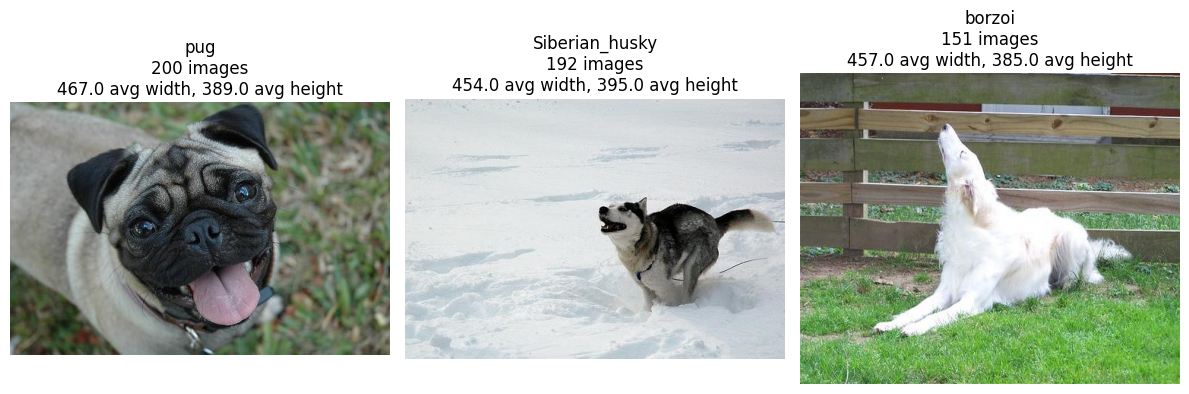

In [4]:
m_n_img = img_df["class_label"].value_counts().values.mean()
m_w = img_df["width"].mean().round(0)
m_h = img_df["height"].mean().round(0)

print(f"{m_n_img} images per class, {m_w} avg width, {m_h} avg height")

classes = ["pug", "Siberian_husky", "borzoi"]

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

for i, c in enumerate(classes):
    _ = img_df.loc[img_df["class_label"] == c]

    # n images
    n_img = _["ID"].nunique()
    # mean width
    m_w = _["width"].mean().round(0)
    # mean height
    m_h = _["height"].mean().round(0)

    # pick image
    img = Image.open(_["img_uri"].to_list()[0])

    axs[i].imshow(img)
    axs[i].axis("off")
    axs[i].set_title(f"{c}\n{n_img} images\n{m_w} avg width, {m_h} avg height")

plt.tight_layout()
plt.show()
plt.close()

In [5]:
img_ds = img_df.loc[img_df["class_label"].isin(classes)]
print(f"original shape {img_df.shape} -> selected {img_ds.shape}")

original shape (20580, 10) -> selected (543, 10)


# <a id='toc3_'></a>[Échantillonnage des images](#toc0_)

Les images doivent être mélangées et échantillonnées en veillant que chaque échantillon ait la même proportion de chaque classe.

Le jeu de données est divisé en 3 :
- entraînement (90%)
  - train (80% x 90%) : pour entraîner le modèle
  - validation (20% x 90%) : pour évaluer le modèle et l'affiner (hyperparamètres, etc.)
- test (10%) : pour éviter toute fuite de données, il est intouché et ne sert qu'à l'inférence ultérieure

La bibliothèque `keras` permet de mélanger et échantillonner automatiquement les images d'entraînement, le jeu de données est donc divisé en train et test dans un premier temps.  
Aussi, les images sont copiées dans les dossiers appropriés pour utiliser pleinement les fonctionnalités de `keras` et éviter la fuite de données.

## <a id='toc3_1_'></a>[Encodage des catégories](#toc0_)

Les modèles privilégient les valeurs numériques, une encodage des catégories est donc à réaliser pour passer des données textuelles à des données numériques.

Ici, il est préférable d'utiliser un encodage numérique simple (un entier par catégorie) au lieu d'un encodage one hot.  
En effet, tant que le modèle travaille sur 3 catégories ce n'est pas un problème mais pour 120 classes la mémoire serait saturée.  
Le one hot est à privilégier surtout en cas de multi-label, ce qui n'est pas le cas ici.

In [6]:
y = img_ds["class_label"]
X = img_ds["img_uri"]

# label_encoder = LabelEncoder()
# y_enc = label_encoder.fit_transform(y)
# for further decoding
# label_encoder.inverse_transform(y_enc)

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

> L'encodage n'est pas réalisé en amont car Keras propose un encodage automatique à la génération des tenseurs.

Copie des images d'entraînement et de test dans les dossiers correspondants

In [7]:
# create samples directories
if not os.path.exists(TRAIN_DIR):
    os.makedirs(TRAIN_DIR)
if not os.path.exists(TEST_DIR):
    os.makedirs(TEST_DIR)
if not os.path.exists(CHKPT_DIR):
    os.makedirs(CHKPT_DIR)


def copy_images(X, dir) -> None:
    i = 0
    for src_uri in X:
        img_name = src_uri.split("/")[-1]
        img_class = src_uri.split("/")[-2].split("-")[-1]
        dest_uri = os.path.join(dir, img_class, img_name)
        # create folder if needed
        if not os.path.exists(os.path.join(dir, img_class)):
            os.makedirs(os.path.join(dir, img_class))
        # copy image
        if not os.path.exists(dest_uri):
            shutil.copy2(src_uri, dest_uri)
        # count processed images
        i += 1
    print(f"{i} images processed")


copy_images(X_train, TRAIN_DIR)
copy_images(X_test, TEST_DIR)

488 images processed
55 images processed


# <a id='toc4_'></a>[Modèle CNN](#toc0_)

## <a id='toc4_1_'></a>[Pré-traitement](#toc0_)

La bibliothèque `keras` fournit un arsenal de solutions pour les réseaux de neurones, notamment poru configurer la manière dont les images vont être pré-traitées.

Elle permet notamment :
- d'aller **chercher les images dans un dossier dédié** (train, test, ...) pour éviter toute fuite de données
- l'**échantillonnage des images** d'entraînement en train / validation (cf. plus haut)
- l'**encodage des classes** (cf. plus haut)
- le **redimensionnement**, nécessaire pour limiter la complexité du modèle et les ressources nécessaires mais aussi parce que les modèles ont besoin d'une entrée fixe
- la **normalisation** qui optimise le fonctionnement des réseaux de neurones (s'assure d'une échelle commune, stabilise l'apprentissage, peut accélérer la convergence, limite la saturation de certaines fonctions d'activation)
  - > ici la normalisation des données à (0-1) s'effectue en divisant les valeurs par 255
- l'**augmentation des données**, qui permet d'appliquer des transformations aux images selon les époques, afin d'augmenter la taille du jeu de données, d'aider le modèle à généraliser et donc prévenir le surapprentissage

## <a id='toc4_2_'></a>[Configuration : hyperparamètres et métriques](#toc0_)

### <a id='toc4_2_1_'></a>[Temps d'entraînement](#toc0_)

La métrique la plus simple à mettre en place est le **temps d'entraînement** car il peut énormément varier en fonction des architectures et paramètres d'un modèle.

Chaque époque est ainsi mesurée, ainsi que le temps total d'entraînement.

### <a id='toc4_2_2_'></a>[Métrique](#toc0_)

La seconde métrique la plus évidente dans un problème de **classification multi-classe** (pas multi-label, à savoir qu'un individu ne peut avoir qu'une classe) est l'*accuracy* (ou *justesse*, *exactitude* ou encore *précision globale*).

Lorsque les classes sont nombreuses ou qu'on est face à un problème multi-label, il est préférable d'utiliser la métrique `TopKCategoricalAccuracy`, qui propose $n$ classes les plus probables.  

Avec 3 classes dans le cas présent, **l'*accuracy* est privilégiée**.

### <a id='toc4_2_3_'></a>[Fonction de coût](#toc0_)

La **fonction de coût** `sparse_categorical_crossentropy` est une fonction de perte spécifiquement conçue pour les problèmes de classification avec plus de deux classes : conçue pour être utilisée avec des modèles dont la sortie est une distribution de probabilité (e.g. `softmax`).

D'autres fonctions de coût existent mais soit elles sont moins adaptées à la problématique, soit elles ne diffèrent que par le mode d'encodage des classes (cf. plus haut).

### <a id='toc4_2_4_'></a>[Époques](#toc0_)

Les **époques (ou *epochs*)** représentent le moment où un modèle a vu la totalité du jeu de données. C'est un paramètre qui sert à limiter l'entraînement d'un modèle à un certain nombre d'epochs maximum.

Arrêter trop tôt peut conduire à avoir parfois un modèle sous-entraîné, mais l'arrêter trop tard peut entraîner un gâchis de ressources et à un sur-apprentissage inutile.

Une bonne pratique est de limiter un nouveau modèle à quelques époques au départ puis d'allonger les entraînements seulement pour les modèles efficaces et le nécessitant.

### <a id='toc4_2_5_'></a>[Taille de batch](#toc0_)

L'entraînement d'un réseau de neurones repose sur un ajustement régulier des poids et biais (*rétropropagation du gradient*) des neurones.  
Afin de ne pas consommer trop de ressources et d'optimiser l'entraînement, le réseau s'entraîne avec un jeu de données divisés en échantillons (*batches*) et l'ajustement des poids se fait à chaque fin de batch.

Le ***batch size*** définit la taille d'un échantillon (en nombre d'images, ici) avant de procéder à l'ajustement des poids.  
Il est couplé au taux d'apprentissage ou ***learning rate***, qui définit l'amplitude avec laquelle les poids sont réajustés.

Ces deux variables sont liées et il y a un équilibre à trouver :
- un batch size très petit nécessite un learning rate moindre sans quoi le modèle aurait beaucoup de mal à trouver un optimum, les ajustements étant fréquents et intenses, d'autant qu'un petit échantillon a des chances de ne pas pouvoir montrer au modèle suffisamment de classes différentes pour apprendre efficacement
- à l'inverse, un batch size très important avec un learning rate faible entraînerait un entraînement très long et peu efficace

### <a id='toc4_2_6_'></a>[Optimiseur](#toc0_)

Un optimiseur ou ***optimizer*** est un algorithme pour ajuster les poids et biais du modèle afin de minimiser la fonction de coût.
La descente de gradient stochastique ou *SGD* (Stochastic Gradient Descent) est le plus célèbre des optimiseurs.

Les relations mathématiques entre *batch size* et *learning rate* étant très complexes, on détermine souvent le batch size en fonction du modèle, de la problématique et des données et on relativise le learning rate avec un optimiseur adapté, qui ajuste automatiquement le taux d'apprentissage.

Un des plus efficaces et populaires est **Adam** (Adaptive Moment Estimation), qui ajuste le taux d'apprentissage pour chaque paramètre, i.e. il permet des mises à jour plus importantes pour les paramètres peu fréquents et plus petites pour les paramètres fréquents.

Une version plus récente et efficace encore est ***AdamW***, qui peut appliquer un déclin progressif du taux d'apprentissage afin d'avoir un taux plus élevé en début d'entraînement et plus bas en fin d'entraînement. Cela permet d'économiser des ressources et du temps tout en permettant une meilleure convergence.

In [8]:
model_name = "a_e16_bs32"
input_size = (224, 224)
batch_size = 32
n_epochs = 16
optimizer = "adam"
loss = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

Pour sauvegarde des poids

In [9]:
chkpt_name = model_name + ".weights.h5"
chkpt_uri = os.path.join(CHKPT_DIR, chkpt_name)

Enregistrement de la configuration (pour journalisation)

In [10]:
model_config = f"""
| Config | Value |
|:---:|:---:|
| **model name** | {model_name} |
| **input size** | {input_size} |
| **batch size** | {batch_size} |
| **n epochs** | {n_epochs} |
| **optimizer** | {optimizer} |
| **loss** | {loss} |
| **metrics** | {metrics} |
| **best weights URI** | {chkpt_uri} |
"""

## <a id='toc4_3_'></a>[Architecture](#toc0_)

La couche de redimensionnement est ajoutée en premier, puis viennent les couches du modèle proprement dit.

Pour un premier test afin d'entraîner la détection de 3 classes sur moins de 500 images, le modèle doit commencer simplement, avec par exemple la configuration suivante à 2 couches convolutives et une couche dense :

In [11]:
model = Sequential(
    [
        # normalization & rescaling
        Rescaling(1.0 / 255, input_shape=(input_size[0], input_size[1], 3)),
        # first conv
        Conv2D(64, (3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        # second conv
        Conv2D(128, (3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        # convert 3D matrix to 1D
        Flatten(),
        # FC layers
        Dense(3, activation="softmax"),
    ]
)

architecture = """
# normalization & rescaling
Rescaling(1.0 / 255, input_shape=(input_size[0], input_size[1], 3)),
# first conv
Conv2D(64, (3, 3), padding="same", activation="relu"),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
# second conv
Conv2D(128, (3, 3), padding="same", activation="relu"),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
# convert 3D matrix to 1D
Flatten(),
# FC layers
Dense(3, activation="softmax"),
"""

/home/jl/projets/oc_p6/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## <a id='toc4_4_'></a>[Données train / val](#toc0_)

Création des tenseurs d'entraînement et de validation à partir des images et dossiers d'entraînement

In [12]:
train_ds, val_ds = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",  # class names upon folders structure
    label_mode="int",  # integer encoding
    validation_split=0.2,  # train / val split
    subset="both",  # returns both train and val datasets
    shuffle=True,  # shuffles images
    seed=42,  # random seed
    image_size=input_size,  # automatic resizing
    batch_size=batch_size,  # tensor shape[0]
)

Found 488 files belonging to 3 classes.
Using 391 files for training.
Using 97 files for validation.


Création du jeu de données de test

In [13]:
test_ds = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",  # class names upon folders structure
    label_mode="int",  # integer encoding
    shuffle=True,  # shuffles images
    seed=42,  # random seed
    image_size=input_size,  # automatic resizing
    batch_size=batch_size,  # tensor shape[0]
)

Found 55 files belonging to 3 classes.


Visualisation des images et classes, pour vérification

2024-07-18 10:10:58.458075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


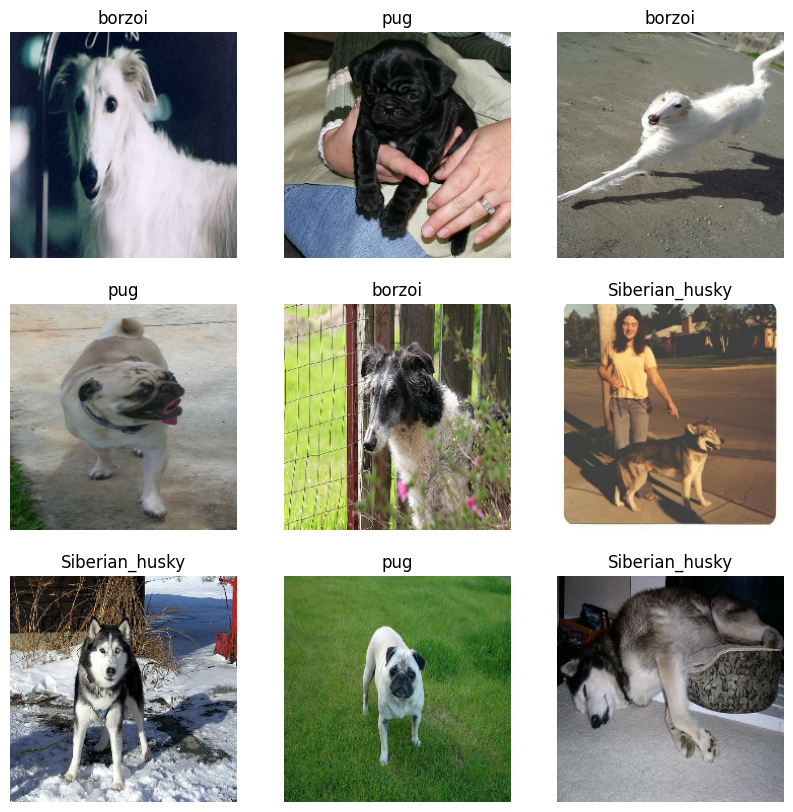

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # display class name
        class_name = train_ds.class_names[labels[i]]
        plt.title(class_name)
        plt.axis("off")
plt.show()

# <a id='toc5_'></a>[🚧 STOP](#toc0_)

In [15]:
stop

NameError: name 'stop' is not defined

## <a id='toc5_1_'></a>[Compilation](#toc0_)

Construction du modèle avec optimiseur, fonction de perte et métrique

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

## <a id='toc5_2_'></a>[Entraînement](#toc0_)

Monitoring : logs pour comparaisons a posteriori

In [ ]:
# set log folder
log_dir = os.path.join(
    LOG_DIR, model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)


# declare callbacks
class TimingCallback(Callback):
    def __init__(self):
        self.logs = []
        self.start_time = None

    def on_train_begin(self, logs={}):
        self.start_time = time.time()

    # log time by epoch
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(time.time() - self.start_time)

    # log total time
    def on_train_end(self, logs={}):
        self.tot_time_sec = time.time() - self.start_time
        self.total_time = f"Total train time: {self.tot_time_sec // 60 :.0f}'{self.tot_time_sec % 60 :.0f}s"


timing_callback = TimingCallback()
checkpoint = ModelCheckpoint(chkpt_uri, save_best_only=True, save_weights_only=True)
# early_stopping = EarlyStopping(
#     monitor="val_loss", patience=10, restore_best_weights=True
# )

tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,  # do not save weights & biases (too much memory)
    write_graph=True,
    write_images=True,
    update_freq="epoch",
)

Entraînement

In [ ]:
%%time

model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=n_epochs,
    callbacks=[timing_callback, checkpoint, tensorboard_callback],
)

Epoch 1/16
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3328 - loss: 3.4007 - val_accuracy: 0.3814 - val_loss: 1.1253
Epoch 2/16
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3584 - loss: 1.1179 - val_accuracy: 0.3711 - val_loss: 1.0837
Epoch 3/16
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4990 - loss: 1.0276 - val_accuracy: 0.5052 - val_loss: 1.0670
Epoch 4/16
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5863 - loss: 0.9116 - val_accuracy: 0.4124 - val_loss: 1.0873
Epoch 5/16
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7334 - loss: 0.7787 - val_accuracy: 0.4021 - val_loss: 1.3482
Epoch 6/16
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7680 - loss: 0.5545 - val_accuracy: 0.4536 - val_loss: 1.3517
Epoch 7/16
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8504 - loss: 0.4230 - val_accuracy: 0.5052 - val_loss: 1.5384
Epoch 8/16
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9257 - loss: 0.2774 - val_accuracy: 0.4845 - val_loss:

## <a id='toc5_3_'></a>[Évaluation](#toc0_)

Évaluation sur le jeu de données de test

In [ ]:
model.load_weights(chkpt_uri)
test_loss, test_acc = model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.4246 - loss: 1.0625


Prédictions sur le jeu de données de test

In [ ]:
predictions = model.predict(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step


Matrice de confusion

2024-07-17 17:45:15.220894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


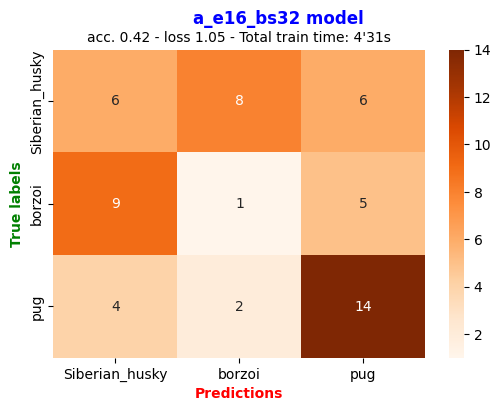

In [ ]:
# get true labels from test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
# convert predictions to classes
predicted_classes = np.argmax(predictions, axis=1)
# compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)
# plot it
conf_mtx_plot = plt.figure(figsize=(6, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=test_ds.class_names,
    yticklabels=test_ds.class_names,
)
plt.suptitle(f"{model_name} model", color="blue", weight="bold")
plt.title(
    f"acc. {test_acc :.02f} - loss {test_loss :.02f} - {timing_callback.total_time}",
    fontsize=10,
)
plt.xlabel("Predictions", color="red", weight="bold")
plt.ylabel("True labels", color="green", weight="bold")
plt.show()

# convert image for Tensorboard
conf_mtx_plot.canvas.draw()
image_array = np.array(conf_mtx_plot.canvas.renderer.buffer_rgba())
conf_mtx_plot_tf = tf.convert_to_tensor(image_array)
conf_mtx_plot_tf = tf.expand_dims(conf_mtx_plot_tf, 0)

### <a id='toc5_3_1_'></a>[Log des modèles et des métriques](#toc0_)

Une bibliothèque très utile pour comparer les modèles est **Tensorboard**, qui s'intègre bien avec `keras`.

Elle permet de stocker les diverses métriques à chaque époque grâce à un système de callback actif durant l'entraînement, ainsi que des métriques a posteriori, par exemple l'efficacité des prédictions sur un jeu de données de test qui n'a pas servi durant l'entraînement.

In [ ]:
# write metrics in tensorboard
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
with file_writer.as_default():
    tf.summary.text("configuration", model_config, step=0)
    tf.summary.text("architecture", architecture, step=0)
    tf.summary.text("total_training_time", timing_callback.total_time, step=0)
    for i, time_per_epoch in enumerate(timing_callback.logs):
        tf.summary.scalar("time_per_epoch", time_per_epoch, step=i + 1)
    tf.summary.image("confusion_matrix", conf_mtx_plot_tf, step=0)

## <a id='toc5_4_'></a>[🚧 Résultats](#toc0_)

- plot courbes acc / loss
- refaire conclusions


Ce premier modèle n'est pas bon sur plusieurs plans :
- il est **instable et fragile** car selon les expériences, même sans changer la configuration, les résultats sont très différents : il y a peu de données et peu d'époques
- son **apprentissage est mauvais** car l'accuracy ne monte pas (ou très peu selon les expériences) sur les données d'entraînement comme de validation et stagne la plupart du temps autour de valeurs aussi faibles que si ses prédictions étaient aléatoires
- il est en **sur-apprentissage** car malgré les résultats médiocres, la fonction de coût descend pour les données d'entraînement mais pas pour celles de validation : le modèle ne sait pas généraliser, il a trop peu d'exemples et les données ne varient pas entre chaque époque

Il est **nécessaire de l'améliorer** en modifiant d'abord quelques paramètres, puis en lui ajoutant des données plus diverses pour s'entraîner

# <a id='toc6_'></a>[Approches d'amélioration](#toc0_)

## <a id='toc6_1_'></a>[Pipeline de test](#toc0_)

Les améliorations suggérées entraînant de nombreux tests du modèle, un pipeline de tests est utilisé, comprenant entraînement et évaluation du modèle.

Les résultats sont ainsi enregistrés dans les logs de Tensorboard, puis montrés ici et analysés.

🚧 **POUR CHAQUE** -> tabl config + archi + conf mtx + courbes acc & loss

- bcp de DA : baisser intensité ou nb couches si pas apprentissage
- **LR** stagne : ajouter une réduction du learning rate en callback pour le réduire si la performance stagne : `reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)`, sinon ajuster explicitement le learning rate : `optimizer_ = AdamW(learning_rate=0.01, decay=0.001)` => initialiser haut pour accélérer le début de l'apprentissage, et le laisser décroître (AdamW plus adapté que Adam pour ajuster le LR)
- Early stopping : stopper l'entraînement si la performance ne s'améliore pas : `early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)`

## <a id='toc6_2_'></a>[Améliorations : complexité](#toc0_)

nombre de couches / complexité / profondeur

## <a id='toc6_3_'></a>[Améliorations : batch size](#toc0_)

- vérif si LR a changé avec BS

## <a id='toc6_4_'></a>[Améliorations : dropout](#toc0_)

Dropout :

Nature des couches convolutives :  
Les couches convolutives ont moins de paramètres et partagent des poids à travers l'image.  
Elles sont déjà plus résistantes au surapprentissage que les couches denses.  
Un taux de dropout trop élevé pourrait perturber excessivement l'apprentissage des caractéristiques spatiales.  

Robustesse des caractéristiques convolutives :
Les caractéristiques apprises par les couches convolutives sont souvent plus robustes et généralisables.  
Un dropout modéré suffit généralement pour améliorer leur généralisation.  

Densité d'information dans les couches denses :  
Les couches entièrement connectées (denses) contiennent beaucoup plus de paramètres.  
Elles sont plus susceptibles de mémoriser les données d'entraînement et donc de surapprendre.  
Un taux de dropout plus élevé aide à prévenir cette mémorisation excessive.

Position dans le réseau :  
Les couches denses sont généralement placées vers la fin du réseau.  
À ce stade, le réseau a déjà extrait des caractéristiques de haut niveau.  
Un dropout plus important ici encourage le réseau à utiliser diverses combinaisons de ces caractéristiques.  

Études empiriques :  
De nombreuses études et expériences ont montré que cette configuration (taux plus faibles pour les couches convolutives, plus élevés pour les couches denses) tend à donner de meilleurs résultats. 

Préservation de l'information spatiale :  
Un dropout trop élevé dans les couches convolutives pourrait trop perturber l'information spatiale cruciale pour la reconnaissance d'images.  

Équilibre entre régularisation et apprentissage :  
Les taux recommandés visent à trouver un équilibre entre une régularisation suffisante et la préservation de la capacité d'apprentissage du réseau.

Il est important de noter que ces recommandations sont des points de départ généraux. La configuration optimale peut varier selon la tâche spécifique, la taille et la nature du dataset, et l'architecture précise du réseau. Il est souvent bénéfique d'expérimenter avec différents taux de dropout pour trouver la meilleure configuration pour votre cas particulier.

## <a id='toc6_5_'></a>[Améliorations : optimizer](#toc0_)

### <a id='toc6_5_1_'></a>[RMSprop (Root Mean Square Propagation)](#toc0_)

RMSprop est souvent considéré comme une alternative efficace à Adam. Il adapte les taux d'apprentissage pour chaque paramètre en fonction de la moyenne des gradients récents.

``` python
from tensorflow.keras.optimizers import RMSprop
optimizer_ = RMSprop(learning_rate=0.001, rho=0.9)
```

### <a id='toc6_5_2_'></a>[SGD (Stochastic Gradient Descent) avec momentum](#toc0_)

SGD avec momentum peut être très efficace, en particulier si vous ajustez correctement le taux d'apprentissage et le momentum.

``` python
from tensorflow.keras.optimizers import SGD
optimizer_ = SGD(learning_rate=0.01, momentum=0.9)
```

### <a id='toc6_5_3_'></a>[AdamW](#toc0_)

AdamW a de + d'Adam qu'il sépare la régularisation des poids (*weight decay*) des mises à jour de gradient.

``` python
from tensorflow.keras.optimizers import AdamW
optimizer_ = AdamW(learning_rate=0.001, weight_decay=0.004)
```

## <a id='toc6_6_'></a>[Améliorations : epoch](#toc0_)

(quand on tient un truc)

## <a id='toc6_7_'></a>[Améliorations : augmentation de données](#toc0_)

Pour améliorer le modèle, il est important d'augmenter les données, peu nombreuses au départ pour chaque classe.  
Chaque image sera ainsi multipliée :
- passage en niveau de gris : pas important, pas métier
- ajout de bruit gaussien
- ajout de contraste
- rotation de 90°
- miroir
- rognage et redimensionnement (zoom)

## <a id='toc6_8_'></a>[🚧 Pré-traitement des données : en parler](#toc0_)

🚧 changer => entraîner le modèle sur ce qu’il va recevoir : utiliser seulement le redimensionnement et garder le preprocess pour améliorer les prédictions  
faire le preprocess à la fin, pour les prédictions seulement


Un pipeline de prétraitement est nécessaire pour chaque image, en prenant en compte la problématique métier (les photos peuvent être floues, mal cadrées, trop ou pas assez zoomées, bruitées) et la problématique du modèle (diminution de la complexité, normalisation des entrées).

Ne pouvant pas vérifier manuellement la qualité de chaque photo, le pipeline de pré-traitement doit pouvoir convenir dans la majorité des situations.  
Certains traitements sont donc effectués systématiquement :
- égalisation
- redimensionnement
- léger filtre médian

Les images ainsi pré-traitées vont dans un dossier dédié et sont nommées selon leur index dans le jeu de données pour éviter tout doublon.

# <a id='toc7_'></a>[🦄🦄 CHECKPOINT 🦄🦄](#toc0_)

In [81]:
model_name_ = "c2x2f2_do2_i32_e16_bs48_adamw_lr001wd05"
input_size_ = (224, 224)
batch_size_ = 48
n_epochs_ = 16
optimizer_ = AdamW(learning_rate=0.001, weight_decay=0.05)
loss_ = "sparse_categorical_crossentropy"
metrics_ = ["accuracy"]

In [82]:
model_ = Sequential(
    [
        # data augmentation
        # ConditionalAugmentation(rate=0.1, input_shape=(input_size_[0], input_size_[1], 3)),
        # normalization & rescaling
        Rescaling(1.0 / 255, input_shape=(input_size_[0], input_size_[1], 3)),
        # first conv
        Conv2D(32, (3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        # second conv
        Conv2D(64, (3, 3), padding="same", activation="relu"),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Dropout(0.2),
        # convert 3D matrix to 1D
        Flatten(),
        # FC layers
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation="softmax"),
    ]
)

architecture_ = """
# normalization & rescaling
Rescaling(1.0 / 255, input_shape=(input_size_[0], input_size_[1], 3)),
# first conv
Conv2D(32, (3, 3), padding="same", activation="relu"),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
# second conv
Conv2D(64, (3, 3), padding="same", activation="relu"),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Dropout(0.2),
# convert 3D matrix to 1D
Flatten(),
# FC layers
Dense(64, activation='relu'),
Dropout(0.5),
Dense(3, activation="softmax"),
"""

/home/jl/projets/oc_p6/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


INFO:root:🧑‍🍳 preparing datasets


Found 488 files belonging to 3 classes.
Using 391 files for training.
Using 97 files for validation.
Found 55 files belonging to 3 classes.


INFO:root:⚙️ compiling
INFO:root:🛎️ declaring callbacks
INFO:root:💪 starting training


Epoch 1/16
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2903 - loss: 4.4965 - val_accuracy: 0.3299 - val_loss: 1.1043
Epoch 2/16
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 857ms/step - accuracy: 0.4155 - loss: 1.0920 - val_accuracy: 0.3918 - val_loss: 1.0926
Epoch 3/16
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 862ms/step - accuracy: 0.3905 - loss: 1.0743 - val_accuracy: 0.4227 - val_loss: 1.0690
Epoch 4/16
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 896ms/step - accuracy: 0.5375 - loss: 0.9751 - val_accuracy: 0.4536 - val_loss: 1.0412
Epoch 5/16
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 867ms/step - accuracy: 0.5737 - loss: 0.8808 - val_accuracy: 0.5258 - val_loss: 1.0518
Epoch 6/16
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 957ms/step - accuracy: 0.7322 - loss: 0.7417 - val_accuracy: 0.5567 - val_loss: 1.1032
Epoch 7/16
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 890ms/step - accuracy: 0.7761 - loss: 0.5207 - val_accuracy: 0.5052 - val_loss: 1.3093
Epoch 8/16
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 976ms/step - accuracy: 0.8210 - loss: 0.4379 - val_accuracy: 0.5670 - val_loss: 

INFO:root:🧐 evaluating model


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5130 - loss: 0.9751 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


INFO:root:📈 plotting results
2024-07-18 16:56:34.610501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


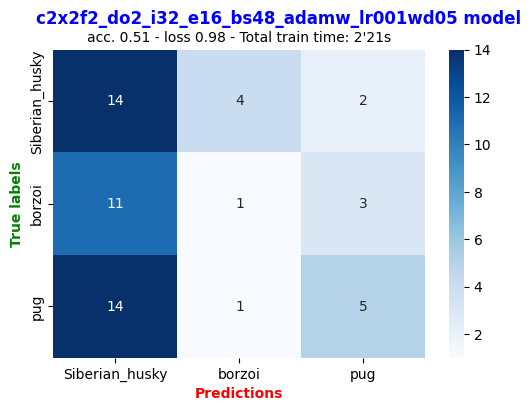

INFO:root:📓 logging results


CPU times: user 7min 56s, sys: 6.99 s, total: 8min 3s
Wall time: 2min 22s


In [83]:
%%time

model_, history_ = evaluate_model(
    model=model_,
    model_arch=architecture_,
    TRAIN_DIR=TRAIN_DIR,
    TEST_DIR=TEST_DIR,
    LOG_DIR=LOG_DIR,
    CHKPT_DIR=CHKPT_DIR,
    model_name=model_name_,
    input_size=input_size_,
    batch_size=batch_size_,
    n_epochs=n_epochs_,
    optimizer=optimizer_,
    loss=loss_,
    metrics=metrics_,
)